In [2]:
import os 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns

from src.data_exploration import *
from src.visualization import *

PATH_TO_GOLDMAN_DATA = "data/LemmaSplitting/LemmaSplitData"
PATH_TO_SIGMORPHON20 = "data/SIGMORPHON2020/train"
PATH_TO_SIGMORPHON22 = "data/2022InflectionST/part1/development_languages"

# Initial Data Exploration

This notebook contains the code for the initial exploration of the Goldman et al. training data in relation to the SIGMORPHON 2020 & 2022 training data.

## Featureset Overlap

The following shows the relationship between full featureset overlap and training size in the Goldman data. 
There seems to be little relationship, and as expected based on the splitting methodology most of the languages have 100% feature overlap. 
However, there are several outliers, the most notable of which is Ludic, with a feature overlap of just 0.303.

Pearson's R:	0.074,	 p = 0.4887022492861393
Spearman:	-0.183,	 p = 0.08431453139707068
Kendall's Tau:	-0.155,	 p = 0.06681463338887599


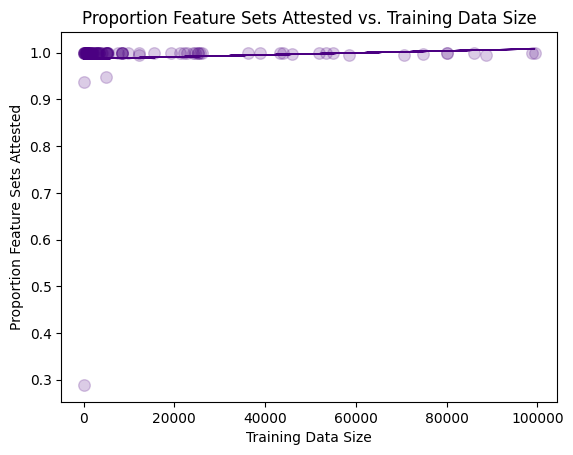

In [19]:
# Get the feature overlap and train sizes
trn_sz, overlap, languages = run_correlation(PATH_TO_GOLDMAN_DATA, train_size, feature_overlap)

# Plot all
plot_stats(trn_sz, 
           overlap, 
           "Training Data Size", 
           "Proportion Feature Sets Attested",
           savefig="../writeup/figs/feats_attested.png")

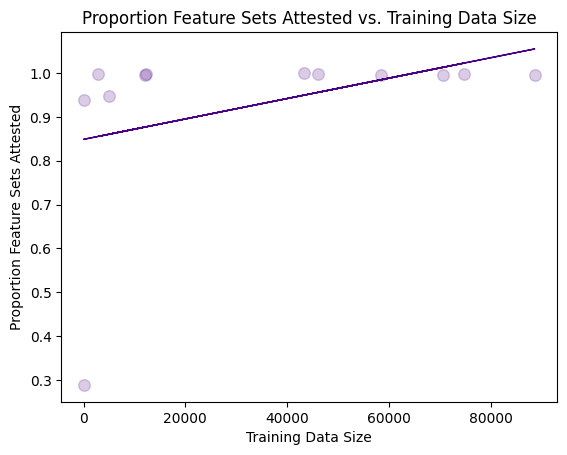

Pearson's R:	0.377,	 p = 0.22729069924555773
Spearman:	0.259,	 p = 0.41677476889913834
Kendall's Tau:	0.121,	 p = 0.6383612539081289


In [3]:
# Plot just those that have overlap < 100%
plot_stats(trn_sz, 
           overlap, 
           "Training Data Size", 
           "Proportion Feature Sets Attested", 
           less=True)

Clearly, if we are splitting my lemmas and have complete paradigms, we _should_ (except in cases of gaps, but even then sufficient data should remedy this) have 100% feature overlap at all times. 
However, the graph above clearly demonstrates that this is not the case. 
We thus investigate the causes of overlap being less than 100%. 

### Train vs. Test Paradigm Size 
Initial exploration shows that dips in overlap are usually caused by a few lemmas in test that appear in _much_ bigger paradigms than words of the same part of speech in train. 
To quantify this, we measure for each part of speech the mean paradigm size for the `training` (train + dev) data, the `test` data, and the `problematic lemmas` in the test data, which are defined as any lemma in the test data that occurs with at least one feature set not attested in train. 

In [4]:
# Iterate over the languages with less than 100% overlap and examine paradigm sizes for each 
for ovlp, lang in zip(overlap, languages):
    if ovlp < 1:
        print(lang, ovlp)
        investigate_feature_overlap(f"{PATH_TO_GOLDMAN_DATA}/{lang}")

iranian/tgk 0.9375
POS: N
	 mean train paradigm size:	 1.000, (stdev: 0.000, n = 51, max = 1)
	 mean test paradigm size:	 1.067, (stdev: 0.249, n = 15)
	 mean problematic lemma size:	 2.000, (stdev: 0.000, n = 1)


POS: V
	 mean train paradigm size:	 1.000, (stdev: 0.000, n = 1, max = 1)
	 POS not attested in test


romance/vec 0.9960362400906002
POS: V
	 mean train paradigm size:	 47.198, (stdev: 4.362, n = 257, max = 57)
	 mean test paradigm size:	 47.730, (stdev: 3.214, n = 74)
	 mean problematic lemma size:	 54.000, (stdev: 7.000, n = 2)


tungusic/evn 0.9480337078651685
POS: N
	 mean train paradigm size:	 1.736, (stdev: 2.192, n = 1630, max = 34)
	 mean test paradigm size:	 1.684, (stdev: 2.191, n = 437)
	 mean problematic lemma size:	 6.000, (stdev: 8.116, n = 15)


POS: V
	 mean train paradigm size:	 2.381, (stdev: 4.062, n = 688, max = 42)
	 mean test paradigm size:	 2.567, (stdev: 5.496, n = 201)
	 mean problematic lemma size:	 6.719, (stdev: 11.676, n = 32)


POS: ADJ
	 mean 

In [5]:
# Verify that every POS attested in test is attested in train, even though full feature sets aren't
for f in [f for f in os.listdir(PATH_TO_GOLDMAN_DATA) if "." not in f]:
    for lang in set([l.strip().split(".")[0] for l in os.listdir(f"{PATH_TO_GOLDMAN_DATA}/{f}")]):
        train, dev, test = parse_files(f"{PATH_TO_GOLDMAN_DATA}/{f}/{lang}")
        train_pos = set([x.split(";")[0] for x in train] + [x.split(";")[0] for x in dev])
        test_pos = set([x.split(";")[0] for x in test])
        assert(all(x in train_pos for x in test_pos))
print("Success!")

Success!


### Quantifying the Difference for Problematic Lemmas 
We can see above that the mean paradigm size for `problematic lemmas` is generally higher than the mean paradigm size for the same POS in train. 
We quantify this in terms of _percent increase_ from the paradigm size in train to the paradigm size for problematic lemmas in test: $\frac{\texttt{average problematic paradigm size} - \texttt{average train paradigm size}}{\texttt{average train paradigm size}}$ for each part of speech in each language.
As a point of comparison, we also measure the percent increase from the average training paradigm size to the _maximum paradigm size_ for the same POS in test for all languages with 100\% feature overlap.
We find a significant difference, measured quantitatively and visualized below.

Problematic difference: 	mean: 437.683 (stdev: 871.027)
Max difference: 	mean: 11.511 (stdev: 34.054)
T-test:	 5.375 (p: 2.8311018338173697e-07)


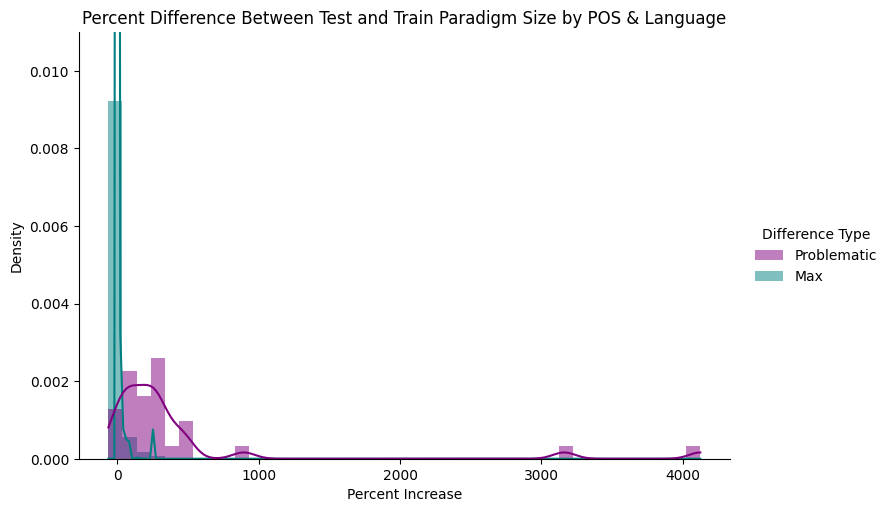

In [6]:
# We'll store the differences and the type of differences in two lists 
differences = []
labels = []

for ovlp, lang in zip(overlap, languages):
    # This gives a dictionary with the mean, stdev, and max paradigm size for train, test, and problematic lemmas
    res = investigate_feature_overlap(f"{PATH_TO_GOLDMAN_DATA}/{lang}", verbose=False)
    # Examine each POS for each language 
    for pos in res:
        label = ""
        # If there's not 100% overlap, measure the difference between the average problematic & train paradigm size
        if ovlp < 1:
            if "problematic" in res[pos]:
                train = res[pos]["train"][0]
                test = res[pos]["problematic"][0]
                label = "Problematic"
        # If there is 100% overlap, measure the difference between the max & train paradigm size 
        else:
            if "test" in res[pos]:
                train = res[pos]["train"][0]
                test = res[pos]["test"][-1]
                label = "Max"
        # If we found one of the above, append the percent increase and label to the list 
        if label:
            difference = 100 * (test - train) / train
            differences.append(difference)
            labels.append(label)
    

# Create a DF for plotting, plot it, and save the plot 
df = pd.DataFrame({"Difference Type": labels, "Percent Increase": differences})
sns.displot(df, 
            palette=["purple", "teal"], 
            linewidth=0, 
            alpha=0.5, 
            x="Percent Increase", 
            hue="Difference Type", 
            kde=True, 
            kde_kws={"bw_method": 0.3, "bw_adjust": 0.3}, 
            binwidth=100, 
            common_norm=False, 
            stat="density",
            aspect=1.5
           )
plt.ylim(0.0, 0.011)
plt.title("Percent Difference Between Test and Train Paradigm Size by POS & Language")
plt.savefig("../writeup/figs/percent_increase.png", dpi=500, bbox_inches='tight')


# Now, we run some stats over the problematic and max data
difference_problematic = df.loc[df['Difference Type'] == "Problematic"]
difference_max = df.loc[df['Difference Type'] == "Max"]

# Get the mean and standard deviation in percent increase
for data in [difference_problematic, difference_max]:
    label = list(data["Difference Type"])[0]
    data = data["Percent Increase"]
    print(f"{label} difference: \tmean: {np.average(data):.3f} (stdev: {np.std(data):.3f})")

# Run an unpaired t-test 
ttest = stats.ttest_ind(difference_problematic["Percent Increase"], difference_max["Percent Increase"])
print(f"T-test:\t {ttest.statistic :.3f} (p: {ttest.pvalue})")

### Relationship Between These Measures and Overlap

Below, we consider the relationship between percent increase from train to problematic lemmas vs. the featureset overlap between test and train.
We also consider the standard deviation in the paradigm size of the problematic lemmas as well as for _all_ lemmas of the given POS in test. 
Each POS for each language represents a unique point.

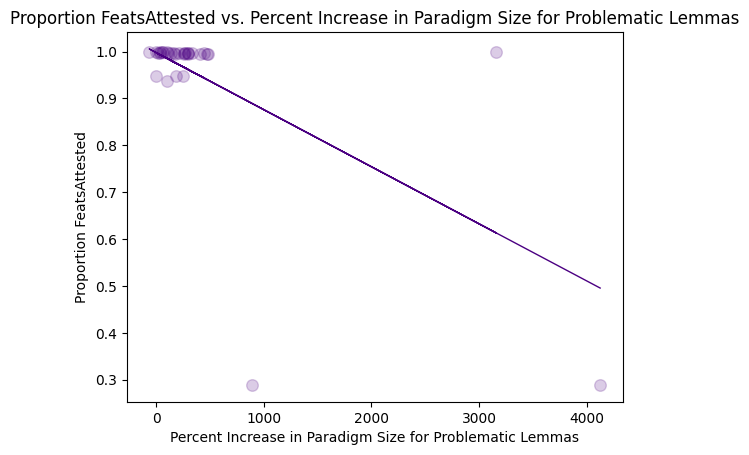

Pearson's R:	-0.613,	 p = 0.0002457827796981978
Spearman:	-0.374,	 p = 0.038434346869136944
Kendall's Tau:	-0.310,	 p = 0.01744474881828313


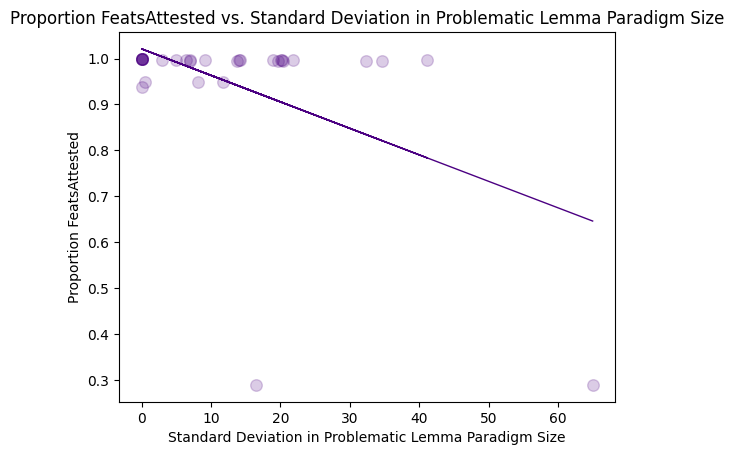

Pearson's R:	-0.483,	 p = 0.005945028345134753
Spearman:	-0.503,	 p = 0.0039658192899067425
Kendall's Tau:	-0.380,	 p = 0.004389443480079927


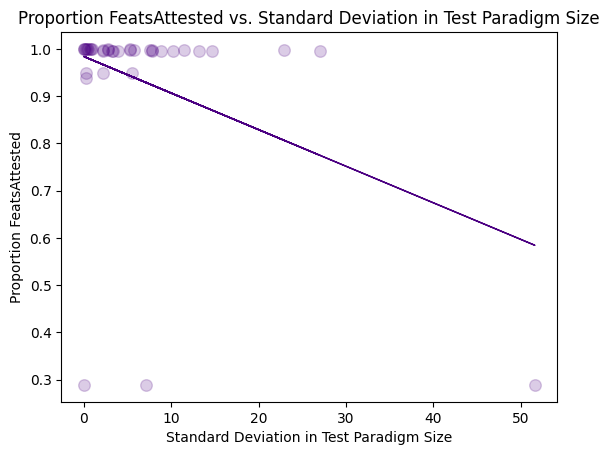

Pearson's R:	-0.389,	 p = 0.018937806204076438
Spearman:	-0.363,	 p = 0.029567026556292262
Kendall's Tau:	-0.287,	 p = 0.017155064175333926


In [7]:
ovlps_problematic = []
ovlps_test = []
problematic_percent_increase = []
problematic_stdevs = []
test_stdevs = []

# Iterate through all the languages with less than 100% overlap and store each POS separately 
for ovlp, lang in zip(overlap, languages):
    res = investigate_feature_overlap(f"{PATH_TO_GOLDMAN_DATA}/{lang}", verbose=False)
    if ovlp < 1: 
        for pos in res:
            if "problematic" in res[pos]:
                # Percent increase in paradigm size 
                train = res[pos]["train"][0]
                test = res[pos]["problematic"][0]
                diff = 100 * (test - train) / train 
                problematic_percent_increase.append(diff)
                # Standard deviation in problematic paradigm size 
                problematic_stdevs.append(res[pos]["problematic"][1])
                ovlps_problematic.append(ovlp)
            if "test" in res[pos]:
                # Standard deviation in test paradigm size 
                test_stdevs.append(res[pos]["test"][1])
                ovlps_test.append(ovlp)

# Plot the percent increase vs. the featureset overlap 
plot_stats(problematic_percent_increase, 
           ovlps_problematic, 
           "Percent Increase in Paradigm Size for Problematic Lemmas", 
           "Proportion FeatsAttested")

# Plot the standard deviation vs. the featureset overlap 
plot_stats(problematic_stdevs,
           ovlps_problematic, 
           "Standard Deviation in Problematic Lemma Paradigm Size", 
           "Proportion FeatsAttested")

# Plot the standard deviation of the test paradigm size vs. the featureset overlap 
plot_stats(test_stdevs, 
           ovlps_test, 
           "Standard Deviation in Test Paradigm Size", 
           "Proportion FeatsAttested")    

We run the same as above, except now each point on the plot corresponds to a single language, and represents the average of the given measure across all POS in that language. 

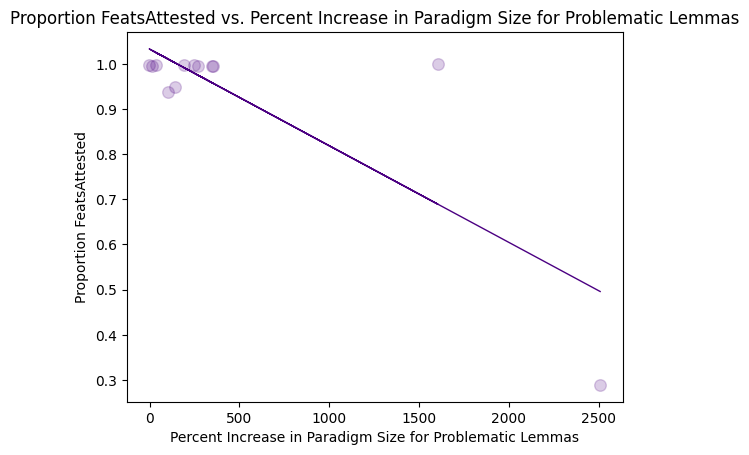

Pearson's R:	-0.812,	 p = 0.0013492923689565233
Spearman:	-0.245,	 p = 0.4432619364501832
Kendall's Tau:	-0.212,	 p = 0.38070480349126185


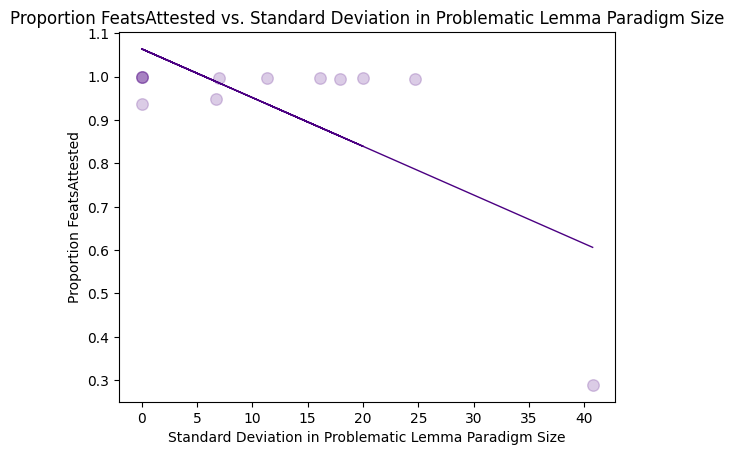

Pearson's R:	-0.696,	 p = 0.011999556147454842
Spearman:	-0.488,	 p = 0.10781378947844335
Kendall's Tau:	-0.381,	 p = 0.09289194088370532


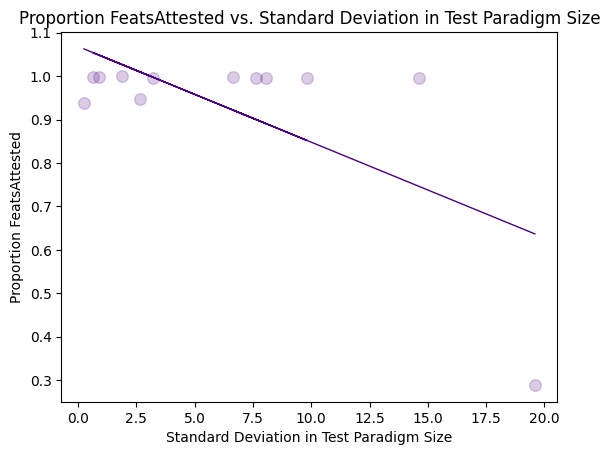

Pearson's R:	-0.659,	 p = 0.01982365284784004
Spearman:	-0.357,	 p = 0.25513775175895725
Kendall's Tau:	-0.242,	 p = 0.3108100139957779


In [8]:
ovlps = []
problematic_percent_increase = []
problematic_stdevs = []
test_stdevs = []

# Iterate through all the languages with less than 100% overlap and store each POS separately 
for ovlp, lang in zip(overlap, languages):
    res = investigate_feature_overlap(f"{PATH_TO_GOLDMAN_DATA}/{lang}", verbose=False)
    if ovlp < 1: 
        # Store for calculating the averages for each language
        local_percent_increase = []
        local_prob_stdevs = []
        local_test_stdevs = []
        for pos in res:
            if "problematic" in res[pos]:
                # Percent increase in paradigm size 
                train = res[pos]["train"][0]
                test = res[pos]["problematic"][0]
                diff = 100 * (test - train) / train 
                local_percent_increase.append(diff)
                # Standard deviation in problematic paradigm size 
                local_prob_stdevs.append(res[pos]["problematic"][1])
            if "test" in res[pos]:
                # Standard deviation in test paradigm size 
                local_test_stdevs.append(res[pos]["test"][1])
                
        # Calculate the averages for each language
        local_percent_increase = np.asarray(local_percent_increase)
        problematic_percent_increase.append(np.mean(local_percent_increase))
        
        local_prob_stdevs = np.asarray(local_prob_stdevs)
        problematic_stdevs.append(np.mean(local_prob_stdevs))
        
        local_test_stdevs = np.asarray(local_test_stdevs)
        test_stdevs.append(np.mean(local_test_stdevs))
        
        ovlps.append(ovlp)

# Plot the percent increase vs. the featureset overlap 
plot_stats(problematic_percent_increase, 
           ovlps, 
           "Percent Increase in Paradigm Size for Problematic Lemmas", 
           "Proportion FeatsAttested")

# Plot the standard deviation vs. the featureset overlap 
plot_stats(problematic_stdevs,
           ovlps, 
           "Standard Deviation in Problematic Lemma Paradigm Size", 
           "Proportion FeatsAttested")

# Plot the standard deviation of the test paradigm size vs. the featureset overlap 
plot_stats(test_stdevs, 
           ovlps, 
           "Standard Deviation in Test Paradigm Size", 
           "Proportion FeatsAttested")    

## Other Potential Effects on Feature Overlap
Here we explore other potential factors that may effect feature overlap.

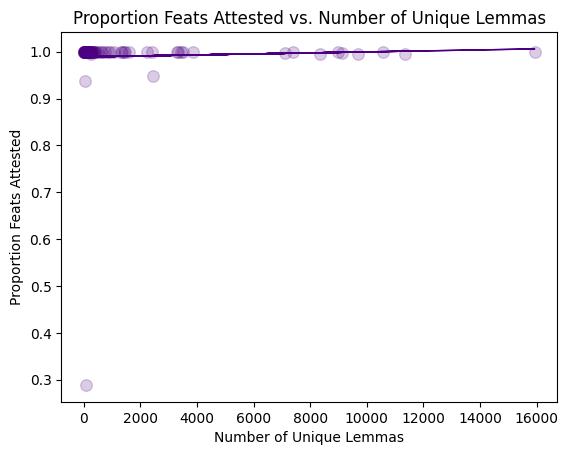

Pearson's R:	0.043,	 p = 0.6862851444652436
Spearman:	-0.320,	 p = 0.002123591143373959
Kendall's Tau:	-0.258,	 p = 0.002324893654064288


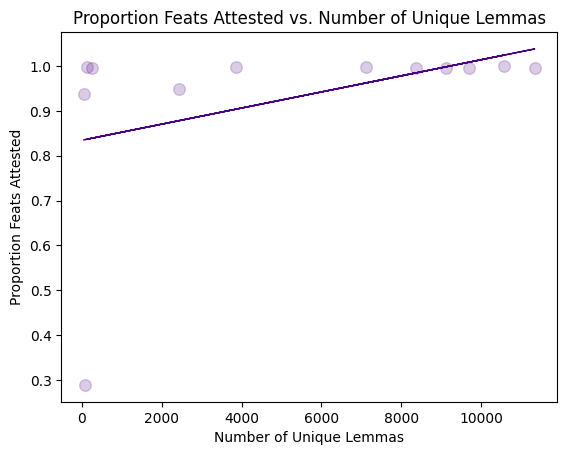

Pearson's R:	0.403,	 p = 0.19342248547521715
Spearman:	0.406,	 p = 0.19083587400450033
Kendall's Tau:	0.242,	 p = 0.3108100139957779


In [9]:
# Number of unique lemmas and correlation vs. feature overlap
unique_lems, overlap, languages = run_correlation(PATH_TO_GOLDMAN_DATA, unique_lemmas, feature_overlap)
plot_stats(unique_lems, overlap, "Number of Unique Lemmas", "Proportion Feats Attested")
plot_stats(unique_lems, overlap, "Number of Unique Lemmas", "Proportion Feats Attested", less=True)

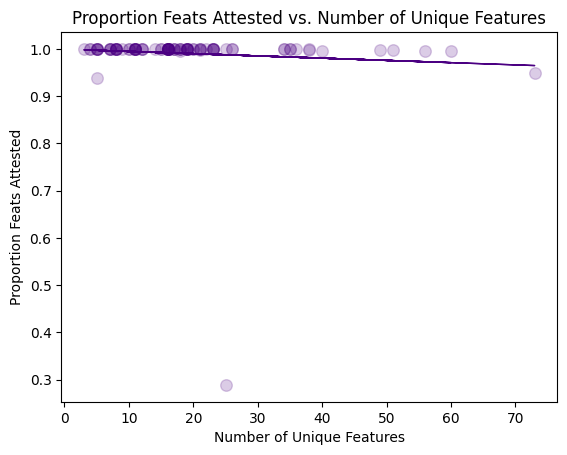

Pearson's R:	-0.081,	 p = 0.44584411600386786
Spearman:	-0.421,	 p = 3.5669499767609506e-05
Kendall's Tau:	-0.352,	 p = 4.3339688130022026e-05


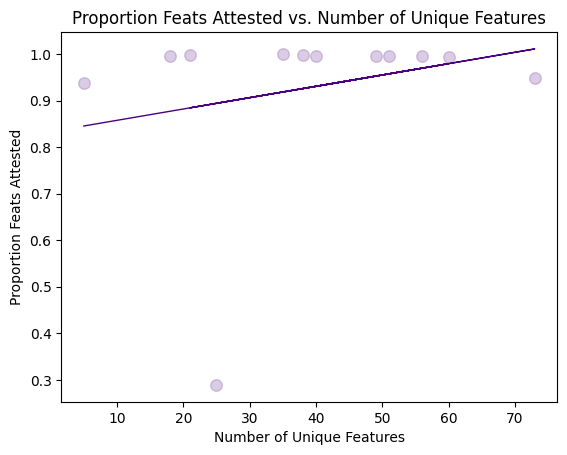

Pearson's R:	0.237,	 p = 0.45886067665488545
Spearman:	-0.021,	 p = 0.9484022252365223
Kendall's Tau:	-0.091,	 p = 0.7373055246579552


In [10]:
# Number of unique features vs. feature overlap
unique_fts, overlap, languages = run_correlation(PATH_TO_GOLDMAN_DATA, unique_features, feature_overlap)
plot_stats(unique_fts, overlap, "Number of Unique Features", "Proportion Feats Attested")
plot_stats(unique_fts, overlap, "Number of Unique Features", "Proportion Feats Attested", less=True)

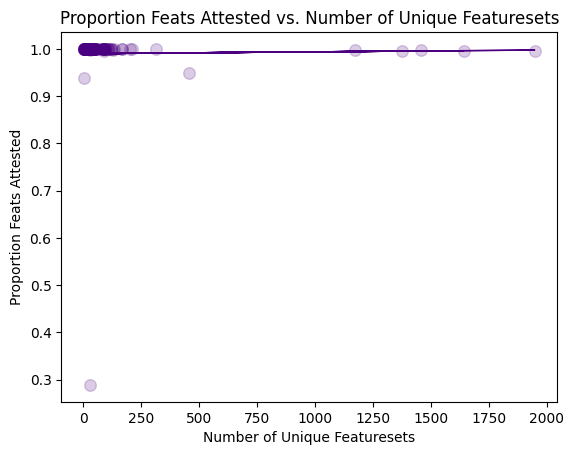

Pearson's R:	0.018,	 p = 0.8671746546131719
Spearman:	-0.342,	 p = 0.0009547452476873431
Kendall's Tau:	-0.283,	 p = 0.0008519765484921734


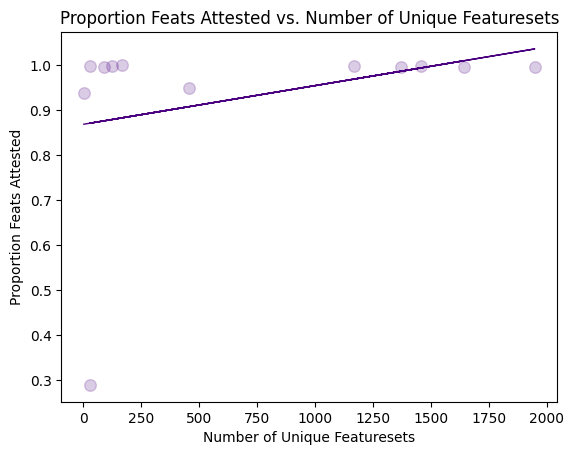

Pearson's R:	0.317,	 p = 0.31590121742423727
Spearman:	0.056,	 p = 0.8628980736949712
Kendall's Tau:	0.000,	 p = 1.0


In [11]:
# Unique feature sets vs. proportion of features attested
unique_ftss, overlap, languages = run_correlation(PATH_TO_GOLDMAN_DATA, unique_featuresets, feature_overlap)
plot_stats(unique_ftss, overlap, "Number of Unique Featuresets", "Proportion Feats Attested")
plot_stats(unique_ftss, overlap, "Number of Unique Featuresets", "Proportion Feats Attested", less=True)

## Within-Data Relationships

Check how various dimensions of the training data are related to one another and to the training size 

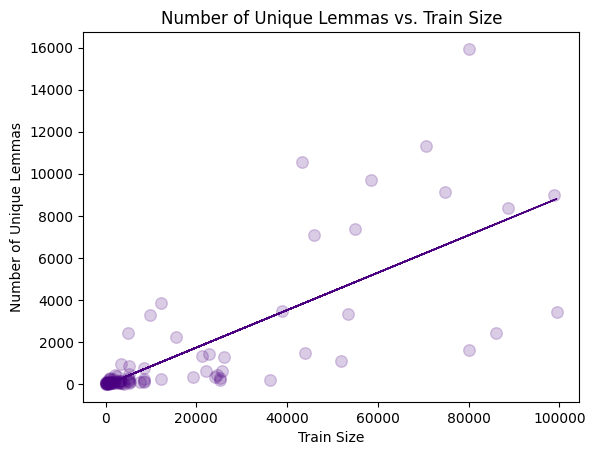

Pearson's R:	0.757,	 p = 6.0860221843791496e-18
Spearman:	0.821,	 p = 3.568948402750255e-23
Kendall's Tau:	0.624,	 p = 3.636800780517223e-18


In [12]:
# Training size vs. number of unique lemmas
train, lemmas, languages = run_correlation(PATH_TO_GOLDMAN_DATA, train_size, unique_lemmas)
plot_stats(train, lemmas, "Train Size", "Number of Unique Lemmas")

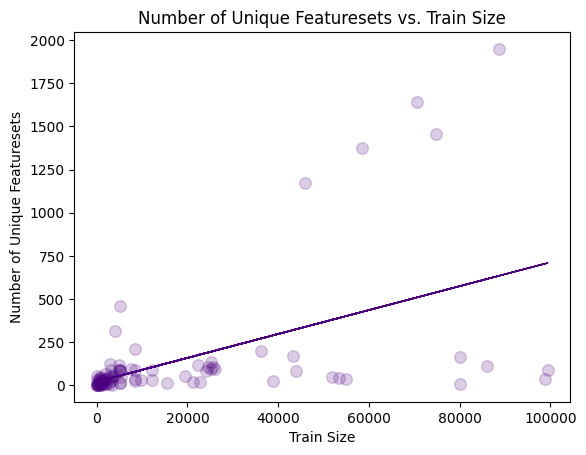

Pearson's R:	0.513,	 p = 2.279553684725066e-07
Spearman:	0.628,	 p = 3.400688729251024e-11
Kendall's Tau:	0.462,	 p = 1.2612341844493853e-10


In [13]:
# Training size vs. number of unique featuresets 
train, features, languages = run_correlation(PATH_TO_GOLDMAN_DATA, train_size, unique_featuresets)
plot_stats(train, features, "Train Size", "Number of Unique Featuresets")

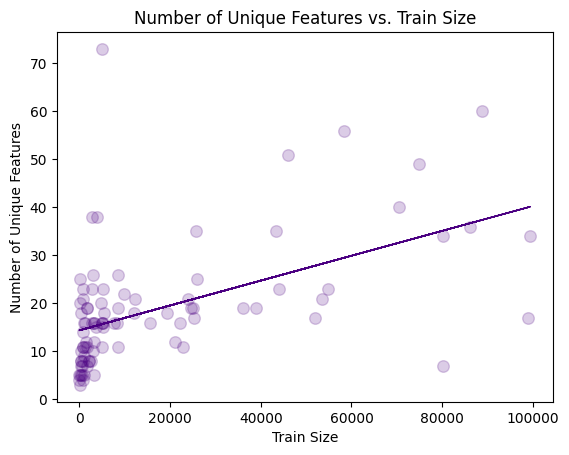

Pearson's R:	0.520,	 p = 1.5093687244905487e-07
Spearman:	0.608,	 p = 2.090987352221549e-10
Kendall's Tau:	0.465,	 p = 2.0269621357563053e-10


In [14]:
# Training size vs. number of unique features
train, features, languages = run_correlation(PATH_TO_GOLDMAN_DATA, train_size, unique_features)
plot_stats(train, features, "Train Size", "Number of Unique Features")

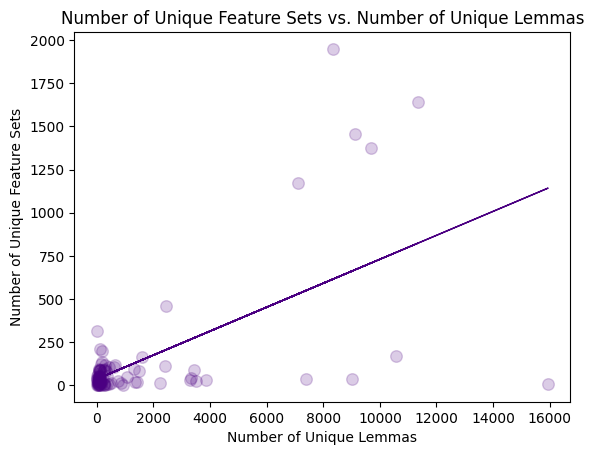

Pearson's R:	0.605,	 p = 2.7461458332750754e-10
Spearman:	0.287,	 p = 0.006158191390928269
Kendall's Tau:	0.209,	 p = 0.0037234121804893315


In [15]:
# Unique feature sets vs. unique lemmas
lemmas, features, languages = run_correlation(PATH_TO_GOLDMAN_DATA, unique_lemmas, unique_featuresets)
plot_stats(lemmas, features, "Number of Unique Lemmas", "Number of Unique Feature Sets")

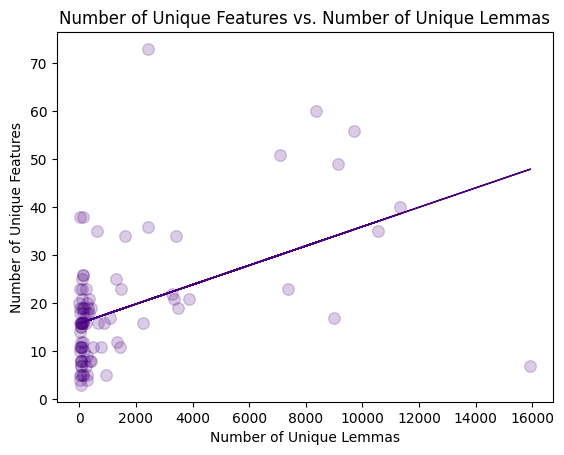

Pearson's R:	0.476,	 p = 2.1732912833399197e-06
Spearman:	0.401,	 p = 8.893470539988188e-05
Kendall's Tau:	0.291,	 p = 6.988155838500093e-05


In [16]:
# Unique features vs. unique lemmas
lemmas, features, languages = run_correlation(PATH_TO_GOLDMAN_DATA, unique_lemmas, unique_features)
plot_stats(lemmas, features, "Number of Unique Lemmas", "Number of Unique Features")

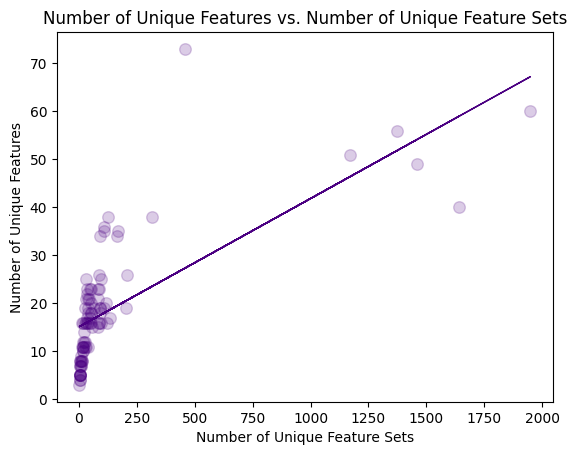

Pearson's R:	0.724,	 p = 7.671167947476654e-16
Spearman:	0.873,	 p = 3.8801821675818444e-29
Kendall's Tau:	0.730,	 p = 2.5228011584902733e-23


In [17]:
# Unique features vs. unique feature sets
feature_sets, features, languages = run_correlation(PATH_TO_GOLDMAN_DATA, unique_featuresets, unique_features)
plot_stats(feature_sets, features, "Number of Unique Feature Sets", "Number of Unique Features")

## Training Size in Goldman vs. SIGMORPHON 2020

Since Goldman et al resampled based on lemmas & sent entire paradigms to the given set, their training sizes differed from the original SIGMORPHON 2020 training sizes. 
They report average decrease in their paper, but not standard deviation, so we explore the distribution of the differences here.

Mean percent increase in training size: -3.499
Standard deviation in training size increase: 6.341


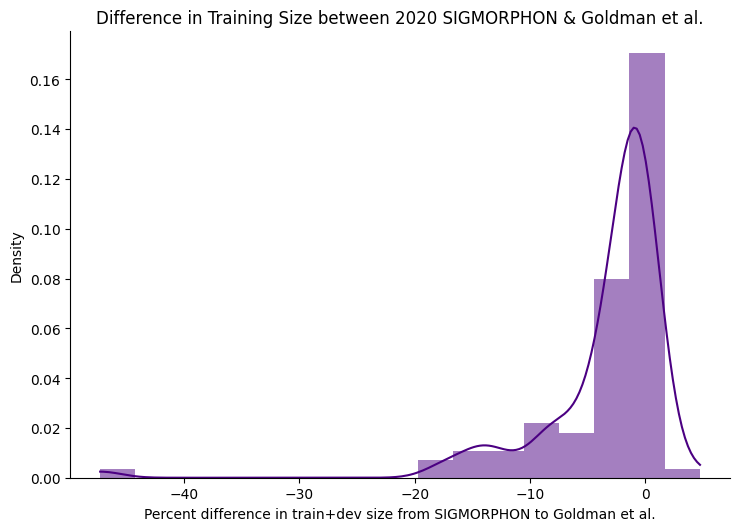

In [18]:
# Get all the training sizes for Goldman
goldman_dict = {}
for f in [f for f in os.listdir(PATH_TO_GOLDMAN_DATA) if "." not in f]:
    for lang in set([l.strip().split(".")[0] for l in os.listdir(f"{PATH_TO_GOLDMAN_DATA}/{f}")]):
        train, dev, _ = parse_files(f"{PATH_TO_GOLDMAN_DATA}/{f}/{lang}")
        goldman_dict[lang] = len(train)

# Get all the training sizes for SIGMORPHON
sigmorphon_dict = {}
for f in [f for f in os.listdir(PATH_TO_SIGMORPHON20) if "." not in f]:
     for lang in set([l.strip().split(".")[0] for l in os.listdir(f"{PATH_TO_SIGMORPHON20}/{f}")]):
        train, dev, _ = parse_files(f"{PATH_TO_SIGMORPHON20}/{f}/{lang}")
        sigmorphon_dict[lang] = len(train) 
        
# Calculate the differences for each language
differences = [100 * (goldman_dict[lang] - sigmorphon_dict[lang]) / sigmorphon_dict[lang] for lang in goldman_dict]
differences = np.asarray(differences)

# Calculate the mean and standard deviation in the percent difference
print(f"Mean percent increase in training size: {np.mean(differences) :.3f}")
print(f"Standard deviation in training size increase: {np.std(differences) :.3f}")

# Plot the results 
sns.displot(differences,
            color="indigo",
            linewidth=0,
            alpha=0.5,
            kde=True,
            binwidth = 3,
            kde_kws = {"bw_adjust": 0.7},
            stat="density",
            aspect=1.5,
           )
plt.xlabel("Percent difference in train+dev size from SIGMORPHON to Goldman et al.")
plt.title("Difference in Training Size between 2020 SIGMORPHON & Goldman et al.")
plt.savefig("../writeup/figs/training_difference.png", dpi=500, bbox_inches='tight')

Is there a relationship between train size and the percent difference in training size between SIGMORPHON 2020 and the Goldman et al data? What about feature set overlap?

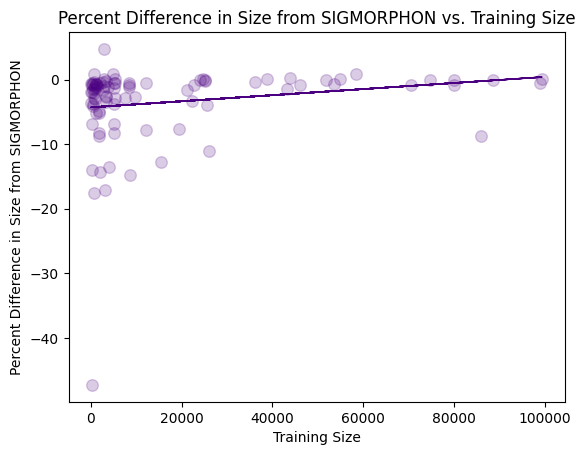

Pearson's R:	0.191,	 p = 0.07106826673193781
Spearman:	0.335,	 p = 0.001228261651984328
Kendall's Tau:	0.221,	 p = 0.0020154126713064994


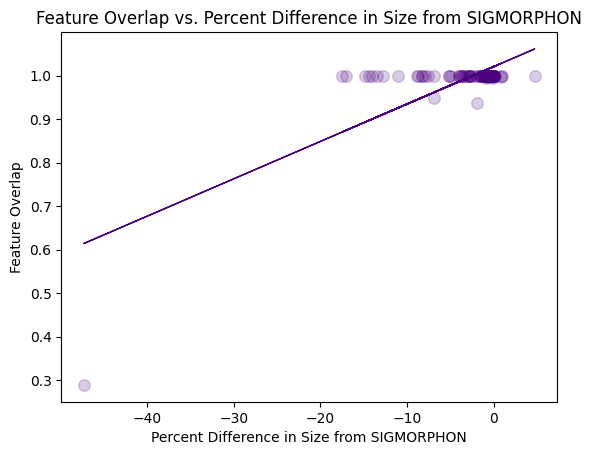

Pearson's R:	0.729,	 p = 3.9933208375528053e-16
Spearman:	-0.063,	 p = 0.5533580130161649
Kendall's Tau:	-0.051,	 p = 0.5425212919627264


In [19]:
# Get the training size and overlap
trn_sz, overlap, languages = run_correlation(PATH_TO_GOLDMAN_DATA, train_size, feature_overlap)

# Recalculate the differences so they're in the right order 
differences = []
for lang in languages:
    lang = lang.split("/")[-1]
    g = goldman_dict[lang]
    s = sigmorphon_dict[lang]
    percent_diff = 100 * (g - s) / s
    differences.append(percent_diff)
    
# Relationship between training size difference and train size in the Goldman data
plot_stats(trn_sz, differences, "Training Size", "Percent Difference in Size from SIGMORPHON")

# Relationship between training size difference and feature overlap in the Goldman data
plot_stats(differences, overlap, "Percent Difference in Size from SIGMORPHON", "Feature Overlap")

## SIGMORPHON 2020 vs. 2022 Training size

There is a big difference between the training data used for the SIGMORPHON 2020 shared task --- from which Goldman et al. drew their data --- and SIGMORPHON 2022, which was the basis of Kodner et al. 
We quantify that difference here.

7 shared langages of 33 in 2022 and 90 in 2020
Shared languages:
	vep
	lud
	krl
	ang
	kaz
	evn
	gml
T-test:	 2.845 (p: 0.0052140126541749205)
Mean train size in 2022: 4452.939 (stdev: 3162.846837508738)
Mean train size in 2020: 17488.933 (stdev: 26035.04482628495)


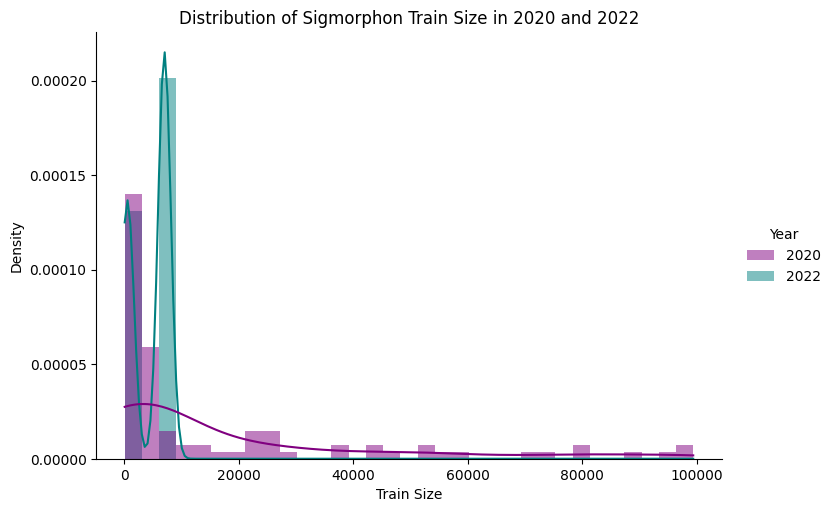

In [20]:
# We alrady collected the training sizes for SIGMORPHON2020 above
lang_to_train20 = sigmorphon_dict


# Get the training sizes for SIGMORPHON 2022: there were large train files only for some languages so check for each
lang_to_train22 = {}
sigmorphon_22_files = [f for f in os.listdir(PATH_TO_SIGMORPHON22) if "train" in f]
langs = set([x.split("_")[0] for x in sigmorphon_22_files])
for lang in langs:
    if f"{lang}_large.train" in sigmorphon_22_files:
        file = f"{lang}_large"
    else:
        file = f"{lang}_small"
    lang_to_train22[lang] = len(open(f"{PATH_TO_SIGMORPHON22}/{file}.train").readlines())

# Find the number of shared languages between the years
print(f"{len([x for x in lang_to_train22 if x in lang_to_train20])} shared langages of {len(lang_to_train22)} in 2022 and {len(lang_to_train20)} in 2020")
print(f"Shared languages:")
for lang in [lang for lang in lang_to_train22 if lang in lang_to_train20]:
    print(f"\t{lang}")

# Create a dataframe with the training sizes and years 
df = pd.DataFrame({"Year": ["2020"] * len(lang_to_train20) + ["2022"] * len(lang_to_train22), 
                   "Train Size": list(lang_to_train20.values()) + list(lang_to_train22.values())}
                 )

# Plot the distribution of training sizes
sns.displot(df, 
            palette=["purple", "teal"], 
            linewidth=0, 
            alpha=0.5, 
            x="Train Size", 
            hue="Year", 
            kde=True, 
            kde_kws={"bw_adjust": 3.5, "bw_method": 0.1}, 
            binwidth=3000, 
            common_norm=False, 
            stat="density",
            aspect=1.5
           )
plt.title("Distribution of Sigmorphon Train Size in 2020 and 2022")
plt.savefig("../writeup/figs/training_size.png", dpi=500, bbox_inches='tight')

# Run an unpaired t-test & calculate means and standard deviations
ttest = stats.ttest_ind(list(lang_to_train20.values()), list(lang_to_train22.values()))
print(f"T-test:\t {ttest.statistic :.3f} (p: {ttest.pvalue})")
print(f"Mean train size in 2022: {np.mean(np.asarray(list(lang_to_train22.values()))) :.3f} (stdev: {np.mean(np.std(list(lang_to_train22.values())))})")
print(f"Mean train size in 2020: {np.mean(np.asarray(list(lang_to_train20.values()))) :.3f} (stdev: {np.mean(np.std(list(lang_to_train20.values())))})")

## Training Lemmas in Goldman vs. SIGMORPHON 2020

Since Goldman et al resampled based on lemmas & sent entire paradigms to the given set, the number of lemmas in their training set differed from the SIGMORPHON 2020 data. 
We explore the distribution of the differences here.

Mean percent increase in training size: -28.846
Standard deviation in training size increase: 5.221


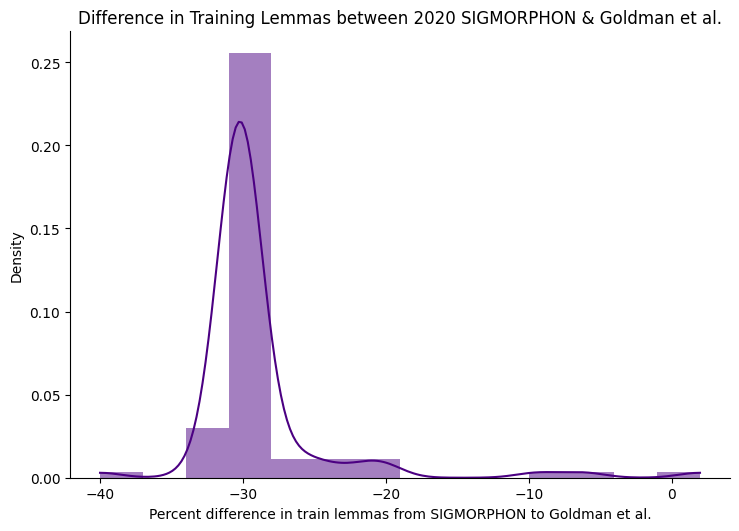

In [20]:
# Get all the training lemmas for Goldman
goldman_dict = {}
for f in [f for f in os.listdir(PATH_TO_GOLDMAN_DATA) if "." not in f]:
    for lang in set([l.strip().split(".")[0] for l in os.listdir(f"{PATH_TO_GOLDMAN_DATA}/{f}")]):
        train, dev, _ = parse_files(f"{PATH_TO_GOLDMAN_DATA}/{f}/{lang}", 0)
        goldman_dict[lang] = len(set(train))

# Get all the training lemmas for SIGMORPHON
sigmorphon_dict = {}
for f in [f for f in os.listdir(PATH_TO_SIGMORPHON20) if "." not in f]:
     for lang in set([l.strip().split(".")[0] for l in os.listdir(f"{PATH_TO_SIGMORPHON20}/{f}")]):
        train, dev, _ = parse_files(f"{PATH_TO_SIGMORPHON20}/{f}/{lang}", 0)
        sigmorphon_dict[lang] = len(set(train)) 
        
# Calculate the differences for each language
differences = [100 * (goldman_dict[lang] - sigmorphon_dict[lang]) / sigmorphon_dict[lang] for lang in goldman_dict]
differences = np.asarray(differences)

# Calculate the mean and standard deviation in the percent difference
print(f"Mean percent increase in training size: {np.mean(differences) :.3f}")
print(f"Standard deviation in training size increase: {np.std(differences) :.3f}")

# Plot the results 
sns.displot(differences,
            color="indigo",
            linewidth=0,
            alpha=0.5,
            kde=True,
            binwidth = 3,
            kde_kws = {"bw_adjust": 0.7},
            stat="density",
            aspect=1.5,
           )
plt.xlabel("Percent difference in train lemmas from SIGMORPHON to Goldman et al.")
plt.title("Difference in Training Lemmas between 2020 SIGMORPHON & Goldman et al.")
plt.savefig("../writeup/figs/lemmas_difference.png", dpi=500, bbox_inches='tight')

18
155
61
17
49
18
37
1
